In [2]:
!pip install torch torchvision tqdm

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = 'cuda:0'
else: device = 'cpu'
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

print(device)

MPS not available because the current PyTorch install was not built with MPS enabled.
cuda:0


# Helper Funcs

In [3]:
import torch.optim as optim

def train(model, trainloader, num_epochs):
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times

      running_loss = 0.0
      total = 0
      correct=0
      for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          # print(model.device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          # print(predicted)
          # print(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
      print(f'[{epoch + 1}] accuracy: {correct/total:.3f}')
      running_loss = 0.0
  print('Finished Training')

def run_trial(model, testloader, num_trials = 1):
  model.to(device)
  accuracy = []
  times = []
  for _ in range(num_trials):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    total_time = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            outputs = model(images)
            end.record()
            torch.cuda.synchronize()
            total_time += start.elapsed_time(end)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            # print(predicted)
            # print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy.append(correct / total)
    times.append(total_time)
  accuracy = np.array(accuracy)
  times = np.array(times)
  avg_accuracy = np.mean(accuracy)
  std_accuracy = np.std(accuracy)
  avg_runtime = np.mean(times)
  std_runtime = np.std(times)
  print(f'Accuracy (Mean, StD) on the 10000 test images: {100 * avg_accuracy}, {100 * std_accuracy} %')
  print(f'Time (Mean, StD) taken: {avg_runtime}, {std_runtime} %')
  return avg_accuracy, std_accuracy, avg_runtime, std_runtime

def run_experiment(model, testloader):
  acc_mean_control, acc_std_control, time_mean_control, time_std_control = run_trial(model, testloader, 5)
  acc_mean, acc_std, time_mean, time_std = [], [], [], []
  trials = np.linspace(0.0, 1.0, 20)
  for var in trials:
      pruned_network = prune_network(model, var)
      result = run_trial(pruned_network, testloader, 20)
      acc_mean.append(result[0])
      acc_std.append(result[1])
      time_mean.append(result[2])
      time_std.append(result[3])

  acc_mean = np.array(acc_mean)
  acc_std = np.array(acc_std)
  time_mean = np.array(time_mean)
  time_std = np.array(time_std)

  fig, (ax1, ax2) = plt.subplots(2)

  ax1.plot(trials, acc_mean, color='red', label='Pruned Network')
  ax1.plot(trials, [acc_mean_control] * len(trials), color='blue', label='Regular Network ')
  ax1.fill_between(trials, acc_mean-acc_std, acc_mean+acc_std,
      alpha=0.1, color='red')

  ax1.set_title('MNIST Accuracy vs. Variance Retained')
  ax1.set_ylabel('Accuracy (%)')

  ax1.legend(loc="lower right")


  ax2.plot(trials, time_mean, color='red', label='Pruned Network')
  ax2.plot(trials, [time_mean_control] * len(trials), color='blue', label='Regular Network')
  ax2.fill_between(trials, time_mean-time_std, time_mean+time_std,
      alpha=0.1, color='red')
  ax2.fill_between(trials, [time_mean_control - time_std_control] * len(trials), [time_mean_control + time_std_control] * len(trials),
      alpha=0.1, color='blue')

  ax2.set_title('Inference Time vs. Variance Retained')
  ax2.set_xlabel('Variance Retained (%)')
  ax2.set_ylabel('Time (s)')

  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                    top=0.9, wspace=0.4,hspace=0.4)



  plt.show()


In [4]:
def preform_pca(data, variance, num_components='None', method='var'):
  data = data.T
  # print(data.shape)
  data = np.array(data)
  A_bar = np.mean(data, axis=1)
  A0 = data - A_bar[:, np.newaxis]
  U, S, VT = np.linalg.svd(A0, full_matrices=True)
  # print('U',U.shape)
  # print('VT',VT.shape)
  if method == 'var':
    total_variance = np.sum(S**2)
    variance_99 = variance * total_variance
    sum_variance = 0
    k = 0
    for i in range(len(S)):
        sum_variance += S[i]**2
        k += 1
        if sum_variance >= variance_99:
            break
  if method == 'comp':
    k = num_components
    # print(k)
  # print(U.shape)
  B = np.dot(data.T, U[:, :k]).T
  return U[:, :k], B.T

In [5]:
import copy
def prune_network(model, variance=0.9):
    # layer_list = [layer.weight.data.numpy().T if isinstance(layer, nn.Linear) else 0 for layer in model.layers]
    new_model = copy.deepcopy(model)
    new_weights = []
    new_biases = []
    old_weights = []
    old_biases = []
    for i, (layer, new_layer) in enumerate(zip(model.layers, new_model.layers)):
      if isinstance(layer, nn.Linear):
        device = layer.weight.device
        if i == 1:
            weights = layer.weight.data.cpu().numpy()
            bias = layer.bias.data.cpu().numpy()
            comp, weights = preform_pca(weights.T, variance=variance, method='var')
            bias = bias @ comp

        elif i > 1 and i < len(model.layers) - 1:
            weights = layer.weight.data.cpu().numpy()
            bias = layer.bias.data.cpu().numpy()
            comp1, weights = preform_pca(weights.T, variance=variance, method='var')
            weights = weights.T
            bias = bias @ comp1

            weights = weights.T
            weights = comp.T @ weights
            comp = comp1

        else:
            weights = layer.weight.data.cpu().numpy().T
            weights = comp.T @ weights
            comp = comp1
            bias = layer.bias.data.cpu().numpy()

        # new_weights.append(weights.T)
        # new_biases.append(bias)
        # old_weights.append(layer.weight.data.numpy())
        # old_biases.append(layer.bias.data.numpy())

        new_layer.weight.data = torch.tensor(weights.T, device=device)
        new_layer.bias.data = torch.tensor(bias, device=device)

    return new_model

# Training/Testing

In [ ]:
class SimpleFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 120),
          nn.Linear(120, 84),
          nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x

class LargeFCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(28 * 28, 128),
          nn.Linear(128, 512),
          nn.Linear(512, 2048),
          nn.Linear(2048, 8192),
          nn.Linear(8192, 2048),
          nn.Linear(2048, 512),
          nn.Linear(512, 128),
          nn.Linear(128, 64),
          nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers(x)
        return x



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize( (0.5), (0.5))])

batch_size = 512

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
fcc_model = SimpleFCC()
train(fcc_model, trainloader, 10)

  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
run_trial(fcc_model, testloader, 1)

Accuracy (Mean, StD) on the 10000 test images: 91.86999999999999, 0.0 %
Time (Mean, StD) taken: 11.930047929286957, 0.0 %


(0.9187, 0.0, 11.930047929286957, 0.0)

In [ ]:
pruned_fcc_model = prune_network(fcc_model)
run_trial(pruned_fcc_model, testloader, 1)


Accuracy (Mean, StD) on the 10000 test images: 91.86999999999999, 0.0 %
Time (Mean, StD) taken: 12.180179172754288, 1.9995803910434424 %
Accuracy (Mean, StD) on the 10000 test images: 19.950000000000003, 0.0 %
Time (Mean, StD) taken: 14.715793639421463, 1.7771248915061004 %
Accuracy (Mean, StD) on the 10000 test images: 19.950000000000003, 0.0 %
Time (Mean, StD) taken: 15.803468845784664, 4.019038066873999 %
Accuracy (Mean, StD) on the 10000 test images: 41.92, 0.0 %
Time (Mean, StD) taken: 16.36476962044835, 7.337630311988 %
Accuracy (Mean, StD) on the 10000 test images: 56.809999999999995, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 14.180481584370137, 4.272661911444235 %
Accuracy (Mean, StD) on the 10000 test images: 56.94999999999999, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 13.77671360000968, 3.2309793064341608 %
Accuracy (Mean, StD) on the 10000 test images: 67.08999999999999, 1.1102230246251565e-14 %
Time (Mean, StD) taken: 13.579948791861534, 3.0736382249915177 %
A

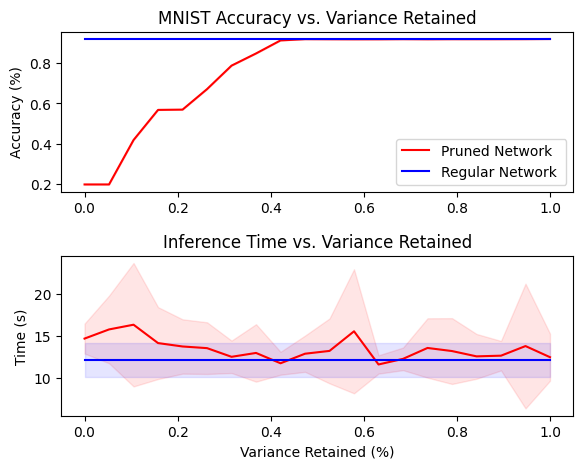

In [ ]:
run_experiment(fcc_model, testloader)


 10%|█         | 1/10 [00:15<02:17, 15.32s/it]

[1] loss: 0.038


 20%|██        | 2/10 [00:28<01:51, 13.96s/it]

[2] loss: 0.021


 30%|███       | 3/10 [00:41<01:35, 13.61s/it]

[3] loss: 0.020


 40%|████      | 4/10 [00:54<01:20, 13.39s/it]

[4] loss: 0.019


 50%|█████     | 5/10 [01:07<01:06, 13.34s/it]

[5] loss: 0.019


 60%|██████    | 6/10 [01:20<00:51, 12.99s/it]

[6] loss: 0.018


 70%|███████   | 7/10 [01:32<00:38, 12.75s/it]

[7] loss: 0.018


 80%|████████  | 8/10 [01:45<00:25, 12.99s/it]

[8] loss: 0.018


 90%|█████████ | 9/10 [02:01<00:13, 13.72s/it]

[9] loss: 0.018


100%|██████████| 10/10 [02:14<00:00, 13.45s/it]

[10] loss: 0.017
Finished Training


Accuracy (Mean, StD) on the 10000 test images: 91.83, 0.0 %
Time (Mean, StD) taken: 170.58694410324097, 0.0 %
Accuracy (Mean, StD) on the 10000 test images: 91.83, 0.0 %
Time (Mean, StD) taken: 275.0920644760132, 1.8859399051686254 %
Accuracy (Mean, StD) on the 10000 test images: 11.350000000000001, 1.3877787807814457e-15 %
Time (Mean, StD) taken: 20.101609551906584, 2.178047635750762 %
Accuracy (Mean, StD) on the 10000 test images: 12.130000000000003, 2.7755575615628914e-15 %
Time (Mean, StD) taken: 19.409907242655756, 6.449954249841746 %
Accuracy (Mean, StD) on the 10000 test images: 20.250000000000004, 2.7755575615628914e-15 %
Time (Mean, StD) taken: 18.161523129045964, 5.038958729471903 %
Accuracy (Mean, StD) on the 10000 test images: 23.109999999999996, 5.551115123125783e-15 %
Time (Mean, StD) taken: 16.63744156807661, 2.5962038806033365 %
Accuracy (Mean, StD) on the 10000 test images: 31.409999999999993, 5.551115123125783e-15 %
Time (Mean, StD) taken: 18.56940319389105, 4.2039062

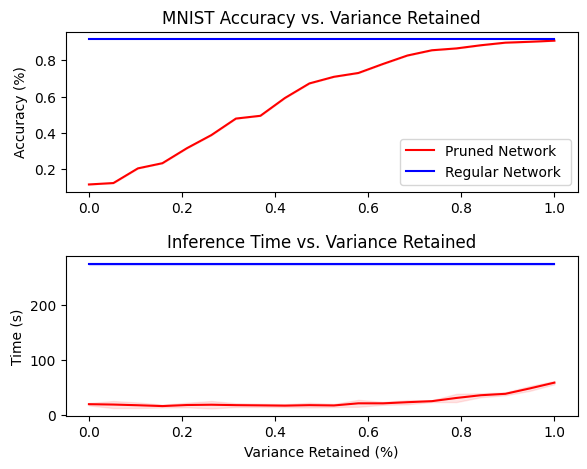

In [ ]:
large_fcc = LargeFCC()
train(large_fcc, trainloader, 10)
run_trial(large_fcc, testloader, 1)
run_experiment(large_fcc, testloader)


# CNN

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = 'cuda:0'
else: device = 'cpu'
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

print(device)


MPS not available because the current PyTorch install was not built with MPS enabled.
cuda:0


In [13]:
# Load image net dataset
from google.colab import drive

drive.mount('/content/drive/')

PATH = "/content/drive/MyDrive/18.065 Project"
! mkdir ./data
# ! cp -r "{PATH}/data/ILSVRC2012_img_val.tar" ./data
# ! cp -r "{PATH}/data/ILSVRC2012_devkit_t12.tar.gz" ./data

import os

transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(256),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 1

trainset = torchvision.datasets.ImageNet(root='./data', transform=transform, split='val')
testset, trainset = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                          shuffle=False, num_workers=2)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mkdir: cannot create directory ‘./data’: File exists


In [9]:
import torchvision.models as models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(pretrained=False).to(device).eval()
resnet = models.resnet50(pretrained=True).to(device).eval()
densenet = models.densenet121(pretrained=True).to(device).eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache

In [10]:
import torch
from torchvision import models
# Print each feature in the AlexNet model
for name, module in alexnet.named_modules():
    print(name, ":", module)


 : AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True

In [10]:
train(alexnet, trainloader, 20)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  5%|▌         | 1/20 [03:06<58:54, 186.02s/it]

[1] loss: 5.282
[1] accuracy: 0.001


 10%|█         | 2/20 [06:11<55:46, 185.89s/it]

[2] loss: 5.181
[2] accuracy: 0.002


 15%|█▌        | 3/20 [09:17<52:37, 185.72s/it]

[3] loss: 5.009
[3] accuracy: 0.007


 20%|██        | 4/20 [12:22<49:30, 185.64s/it]

[4] loss: 4.784
[4] accuracy: 0.013


 25%|██▌       | 5/20 [15:28<46:24, 185.63s/it]

[5] loss: 4.510
[5] accuracy: 0.028


 30%|███       | 6/20 [18:35<43:25, 186.11s/it]

[6] loss: 4.253
[6] accuracy: 0.042


 35%|███▌      | 7/20 [21:40<40:14, 185.76s/it]

[7] loss: 4.013
[7] accuracy: 0.062


 40%|████      | 8/20 [24:46<37:09, 185.77s/it]

[8] loss: 3.759
[8] accuracy: 0.088


 45%|████▌     | 9/20 [27:51<34:01, 185.57s/it]

[9] loss: 3.472
[9] accuracy: 0.124


 50%|█████     | 10/20 [30:56<30:55, 185.56s/it]

[10] loss: 3.105
[10] accuracy: 0.177


 55%|█████▌    | 11/20 [34:03<27:53, 185.94s/it]

[11] loss: 2.632
[11] accuracy: 0.261


 60%|██████    | 12/20 [37:11<24:52, 186.50s/it]

[12] loss: 2.032
[12] accuracy: 0.393


 65%|██████▌   | 13/20 [40:18<21:46, 186.61s/it]

[13] loss: 1.358
[13] accuracy: 0.568


 70%|███████   | 14/20 [43:25<18:39, 186.63s/it]

[14] loss: 0.767
[14] accuracy: 0.740


 75%|███████▌  | 15/20 [46:31<15:32, 186.46s/it]

[15] loss: 0.428
[15] accuracy: 0.849


 80%|████████  | 16/20 [49:36<12:24, 186.13s/it]

[16] loss: 0.273
[16] accuracy: 0.901


 85%|████████▌ | 17/20 [52:43<09:18, 186.28s/it]

[17] loss: 0.201
[17] accuracy: 0.928


 90%|█████████ | 18/20 [55:50<06:13, 186.67s/it]

[18] loss: 0.184
[18] accuracy: 0.932


 95%|█████████▌| 19/20 [58:56<03:06, 186.53s/it]

[19] loss: 0.146
[19] accuracy: 0.947


100%|██████████| 20/20 [1:02:02<00:00, 186.14s/it]

[20] loss: 0.141
[20] accuracy: 0.949
Finished Training


In [31]:
with torch.no_grad():
  correct = 0
  total = 0
  conv1_results = []
  conv2_results = []
  conv3_results = []
  conv4_results = []
  conv5_results = []
  for i, (im, label) in enumerate(iter(trainloader)):
      if i > 1000: break
      # x = im[None, :, :, :]
      x = im
      print(x.shape)
      x = x.to(device)
      label = label.to(device)
      x = alexnet.features[0](x)
      conv1_results.append(x)
      x = alexnet.features[1](x)
      x = alexnet.features[2](x)
      x = alexnet.features[3](x)
      conv2_results.append(x)
      x = alexnet.features[4](x)
      x = alexnet.features[5](x)
      x = alexnet.features[6](x)
      conv3_results.append(x)
      x = alexnet.features[7](x)
      x = alexnet.features[8](x)
      conv4_results.append(x)
      x = alexnet.features[9](x)
      x = alexnet.features[10](x)
      conv5_results.append(x)
      x = alexnet.features[11](x)
      x = alexnet.features[12](x)
      x = alexnet.avgpool(x)
      x = torch.flatten(x, 1)
      x = alexnet.classifier[0](x)
      x = alexnet.classifier[1](x)
      x = alexnet.classifier[2](x)
      x = alexnet.classifier[3](x)
      x = alexnet.classifier[4](x)
      x = alexnet.classifier[5](x)
      x = alexnet.classifier[6](x)
      _, predicted = torch.max(x.data, 1)
      print(predicted)
      total += x.shape[0]
      correct += (predicted == label).sum()
  print(correct/total)


torch.Size([1, 3, 227, 227])
tensor([718], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([76], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([900], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([289], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([406], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([176], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([408], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([762], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([784], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([230], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([888], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([745], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([943], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([538], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([469], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([297], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([884]

In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

21

In [32]:
feature_matrix_1 = conv1_results[0].permute((0,2,3,1)).flatten(start_dim=0, end_dim=-2)
print(feature_matrix_1.shape)
comp, mat = preform_pca(feature_matrix_1.cpu().detach().numpy(), 0.99)
print(comp.shape)
print(mat.shape)
reduced_channels_1 = comp.shape[1]

feature_matrix_1 = conv2_results[0].permute((0,2,3,1)).flatten(start_dim=0, end_dim=-2)
print(feature_matrix_1.shape)
comp, mat = preform_pca(feature_matrix_1.cpu().detach().numpy(), 0.99)
print(comp.shape)
print(mat.shape)
reduced_channels_2 = comp.shape[1]


feature_matrix_1 = conv3_results[0].permute((0,2,3,1)).flatten(start_dim=0, end_dim=-2)
print(feature_matrix_1.shape)
comp, mat = preform_pca(feature_matrix_1.cpu().detach().numpy(), 0.99)
print(comp.shape)
print(mat.shape)
reduced_channels_3 = comp.shape[1]



feature_matrix_1 = conv4_results[0].permute((0,2,3,1)).flatten(start_dim=0, end_dim=-2)
print(feature_matrix_1.shape)
comp, mat = preform_pca(feature_matrix_1.cpu().detach().numpy(), 0.9999)
print(comp.shape)
print(mat.shape)
reduced_channels_4 = comp.shape[1]

torch.Size([3136, 64])
(64, 41)
(3136, 41)
torch.Size([729, 192])
(192, 62)
(729, 62)
torch.Size([169, 384])
(384, 64)
(169, 64)
torch.Size([169, 256])
(256, 145)
(169, 145)


In [33]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, reduced_channels_1, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(reduced_channels_1, reduced_channels_2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(reduced_channels_2, reduced_channels_3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels_3, reduced_channels_4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels_4, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
new_alexnet = AlexNet()

In [34]:
train(new_alexnet, trainloader, 20)

  5%|▌         | 1/20 [19:53<6:17:55, 1193.47s/it]

[1] loss: 169.436
[1] accuracy: 0.001


 10%|█         | 2/20 [39:46<5:58:00, 1193.37s/it]

[2] loss: 169.380
[2] accuracy: 0.001


 15%|█▌        | 3/20 [59:41<5:38:20, 1194.17s/it]

[3] loss: 169.372
[3] accuracy: 0.001


 20%|██        | 4/20 [1:19:38<5:18:40, 1195.00s/it]

[4] loss: 169.369
[4] accuracy: 0.001


 25%|██▌       | 5/20 [1:39:38<4:59:14, 1196.97s/it]

[5] loss: 169.364
[5] accuracy: 0.001


 30%|███       | 6/20 [1:59:34<4:39:13, 1196.67s/it]

[6] loss: 169.352
[6] accuracy: 0.001


 35%|███▌      | 7/20 [2:19:30<4:19:11, 1196.28s/it]

[7] loss: 169.350
[7] accuracy: 0.001


 40%|████      | 8/20 [2:39:27<3:59:19, 1196.66s/it]

[8] loss: 169.325
[8] accuracy: 0.001


 45%|████▌     | 9/20 [2:59:21<3:39:15, 1195.91s/it]

[9] loss: 168.815
[9] accuracy: 0.002


 50%|█████     | 10/20 [3:19:17<3:19:17, 1195.79s/it]

[10] loss: 167.414
[10] accuracy: 0.002


 55%|█████▌    | 11/20 [3:39:13<2:59:21, 1195.72s/it]

[11] loss: 165.467
[11] accuracy: 0.004


 60%|██████    | 12/20 [3:59:08<2:39:24, 1195.60s/it]

[12] loss: 161.783
[12] accuracy: 0.006


 65%|██████▌   | 13/20 [4:19:05<2:19:32, 1196.07s/it]

[13] loss: 157.522
[13] accuracy: 0.009


 70%|███████   | 14/20 [4:39:01<1:59:36, 1196.07s/it]

[14] loss: 154.370
[14] accuracy: 0.012


 75%|███████▌  | 15/20 [4:58:54<1:39:35, 1195.06s/it]

[15] loss: 151.691
[15] accuracy: 0.017


 80%|████████  | 16/20 [5:18:49<1:19:40, 1195.17s/it]

[16] loss: 149.823
[16] accuracy: 0.017


 85%|████████▌ | 17/20 [5:38:44<59:45, 1195.09s/it]  

[17] loss: 148.503
[17] accuracy: 0.021


 90%|█████████ | 18/20 [5:58:38<39:49, 1194.81s/it]

[18] loss: 147.416
[18] accuracy: 0.022


 95%|█████████▌| 19/20 [6:18:35<19:55, 1195.35s/it]

[19] loss: 146.382
[19] accuracy: 0.025


100%|██████████| 20/20 [6:38:32<00:00, 1195.61s/it]

[20] loss: 145.447
[20] accuracy: 0.026
Finished Training


In [35]:
with torch.no_grad():
  correct = 0
  total = 0
  conv1_results = []
  conv2_results = []
  conv3_results = []
  conv4_results = []
  conv5_results = []
  for i, (im, label) in enumerate(iter(trainloader)):
      if i > 1000: break
      # x = im[None, :, :, :]
      x = im
      print(x.shape)
      x = x.to(device)
      label = label.to(device)
      x = new_alexnet.features[0](x)
      conv1_results.append(x)
      x = new_alexnet.features[1](x)
      x = new_alexnet.features[2](x)
      x = new_alexnet.features[3](x)
      conv2_results.append(x)
      x = new_alexnet.features[4](x)
      x = new_alexnet.features[5](x)
      x = new_alexnet.features[6](x)
      conv3_results.append(x)
      x = new_alexnet.features[7](x)
      x = new_alexnet.features[8](x)
      conv4_results.append(x)
      x = new_alexnet.features[9](x)
      x = new_alexnet.features[10](x)
      conv5_results.append(x)
      x = new_alexnet.features[11](x)
      x = new_alexnet.features[12](x)
      x = new_alexnet.avgpool(x)
      x = torch.flatten(x, 1)
      x = new_alexnet.classifier[0](x)
      x = new_alexnet.classifier[1](x)
      x = new_alexnet.classifier[2](x)
      x = new_alexnet.classifier[3](x)
      x = new_alexnet.classifier[4](x)
      x = new_alexnet.classifier[5](x)
      x = new_alexnet.classifier[6](x)
      _, predicted = torch.max(x.data, 1)
      print(predicted)
      total += x.shape[0]
      correct += (predicted == label).sum()
  print(correct/total)


torch.Size([1, 3, 227, 227])
tensor([619], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([405], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([809], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([221], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([109], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([255], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([153], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([856], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([288], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([925], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([924], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([21], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([819], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([661], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([92], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([98], device='cuda:0')
torch.Size([1, 3, 227, 227])
tensor([803], 

In [52]:

weights_1 = alexnet.features[0].weight.cpu().detach().numpy()
bias_1 = alexnet.features[0].bias.cpu().detach().numpy()
weights_2 = alexnet.features[3].weight.cpu().detach().numpy()
print(weights_1.shape)


weights_1 = (comp.T @ weights_1.reshape((64, weights_1.shape[1]*weights_1.shape[2]**2 ))).reshape((comp.shape[1], *weights_1.shape[1:]))
bias_1 = comp.T @ bias_1
weights_2 = weights_2.transpose((1,0,2,3))
print(weights_2.shape)
weights_2 = (comp.T @ weights_2.reshape((64, weights_2.shape[1]*weights_2.shape[2]**2 ))).reshape((comp.shape[1], *weights_2.shape[1:]))
weights_2 = weights_2.transpose((1,0,2,3))

print(weights_1.shape)
print(bias_1.shape)
print(weights_2.shape)

alexnet.features[0].weight.data = torch.tensor(weights_1).to(device)
alexnet.features[0].bias.data = torch.tensor(bias_1).to(device)
alexnet.features[3].weight.data = torch.tensor(weights_2).to(device)


(64, 3, 11, 11)
(64, 192, 5, 5)
(61, 3, 11, 11)
(61,)
(192, 61, 5, 5)


In [ ]:
new_weights = []
new_biases = []
old_weights = []
old_biases = []
for i, layer in enumerate(net.layers):
  if isinstance(layer, nn.Linear):
    # print(layer.weight.data.numpy().shape)
    if i == 1:
        comp, weights = preform_pca(layer.weight.data.numpy().T, variance=0.6, method='var')
        ouput_dim = weights.shape
        bias = np.dot(layer.bias.data.numpy(), comp)
        # print(bias.shape)

    elif i > 1 and i < len(layer_list) - 1:
        weights = layer.weight.data.numpy()
        # print(weights.shape)
        comp1, weights = preform_pca(weights.T, variance=0.6, method='var')
        weights = weights.T
        ouput_dim2 = weights.shape
        # print(weights.shape)
        # print(ouput_dim2.shape)
        bias = np.dot(layer.bias.data.numpy(), comp1)

        # comp2, weights = preform_pca(weights, variance=0.9, num_components=ouput_dim[1], method='comp')
        weights = weights.T
        weights = comp.T @ weights
        comp = comp1
        # weights = weight
        ouput_dim3 = weights.shape
        # print(layer.bias.data.numpy().shape)
        # print(comp.shape, ouput_dim3)
        # print(ouput_dim3)
    else:
        # print(layer.weight.data.numpy().T.shape)
        # print(ouput_dim3[1])
        # comp, weights = preform_pca(layer.weight.data.numpy(), variance=0.9, num_components=ouput_dim3[1], method='comp')
        # weights = weights.T
        # ouput_dim4 = weights.shape
        weights = layer.weight.data.numpy().T
        weights = comp.T @ weights
        comp = comp1
        bias = layer.bias.data.numpy()

        # print(ouput_dim4)
    # print(bias.shape)

    new_weights.append(weights.T)
    new_biases.append(bias)
    old_weights.append(layer.weight.data.numpy())
    old_biases.append(layer.bias.data.numpy())
    # layer.weight.data = torch.from_numpy(components).type_as(layer.weight.data)
    # print(components.shape)
print([w.shape for w in new_weights])
print([w.shape for w in old_weights])
print([w.shape for w in new_biases])
print([w.shape for w in old_biases])

In [ ]:
tensor = torch.randn(3, 64, 11, 11)
tensor = tensor.view(tensor.shape[2]*tensor.shape[3], tensor.shape[0], tensor.shape[1])
print(tensor.shape)
U, S, VT = np.linalg.svd(tensor, full_matrices=False)
print(U.shape, S.shape, VT.shape)
# print(S)

torch.Size([121, 3, 64])
(121, 3, 3) (121, 3) (121, 3, 64)


In [ ]:
diag(S)

NameError: name 'diag' is not defined

In [ ]:
sum_squares = np.sum(S, axis=0)
sum_squares

array([1086.4126 ,  955.8705 ,  834.61926], dtype=float32)

In [ ]:
def preform_pca(tensor, variance, num_components='None', method='var'):
  tensor = tensor.view(tensor.shape[2]*tensor.shape[3], tensor.shape[0], tensor.shape[1])

  mean = torch.mean(tensor, dim=0)
  A0 = tensor - mean

  U, S, VT = np.linalg.svd(A0, full_matrices=True)

  if method == 'var':
    total_variance = np.sum(S**2)
    variance_99 = variance * total_variance
    sum_variance = np.zeroes((3,))
    k = 0
    for i in range(len(S)):
        sum_variance += S[i]**2
        k += 1
        if sum_variance >= variance_99:
            break
  if method == 'comp':
    k = num_components

  B = np.dot(data.T, U[:, :k]).T
  return U[:, :k], B.T

In [ ]:
preform_pca(torch.randn(64, 3, 11, 11), 0.9, num_components='None', method='var')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import torch

def perform_pca(tensor, variance, num_components=None, method='var'):
    # Flatten the tensor from [N, C, H, W] to [N, C*H*W] to treat each pixel and channel as features
    tensor = tensor.view(tensor.shape[0], -1)

    # Calculate the mean along the batch dimension (N) and center the data
    mean = torch.mean(tensor, dim=0, keepdim=True)
    A0 = tensor - mean

    # Perform SVD using PyTorch on the centered data
    U, S, V = torch.linalg.svd(A0, full_matrices=False)

    if method == 'var':
        total_variance = torch.sum(S ** 2)
        variance_threshold = variance * total_variance
        cumulative_variance = torch.cumsum(S**2, dim=0)
        k = (cumulative_variance < variance_threshold).sum().item() + 1
    elif method == 'comp':
        k = num_components  # Ensure num_components is an integer

    # Use only the top k components
    U_k = U[:, :k]

    # Project the data onto the k principal components
    B_transformed = torch.mm(A0, V[:, :k])  # [N, k]

    # Reshape B_transformed to [H*W, C, k]
    h, w = tensor.shape[1] // (tensor.shape[0] * tensor.shape[2]), tensor.shape[2]  # Assume H and W are the last two dimensions
    B = B_transformed.view(tensor.shape[0], h, w, k).permute(1, 2, 0, 3)  # Reshape and permute to [H*W, C, N, k] and then merge N into k

    return U_k, B

# Example usage
tensor = torch.randn(64, 3, 11, 11)  # Example tensor
U, B = perform_pca(tensor, 0.9, num_components=30, method='comp')
print("Shape of U:", U.shape)
print("Shape of B:", B.shape)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x363 and 64x30)

In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
from torchvision import models

for name, parameter in alexnet.named_parameters():
    if parameter.requires_grad and "weight" in name:
        print(f"{name}:")
        print("Weights' Dimensions:", parameter.data.shape)
        # print("Weights' Values:\n", parameter.data, "\n")


features.0.weight:
Weights' Dimensions: torch.Size([64, 3, 11, 11])
features.3.weight:
Weights' Dimensions: torch.Size([192, 64, 5, 5])
features.6.weight:
Weights' Dimensions: torch.Size([384, 192, 3, 3])
features.8.weight:
Weights' Dimensions: torch.Size([256, 384, 3, 3])
features.10.weight:
Weights' Dimensions: torch.Size([256, 256, 3, 3])
classifier.1.weight:
Weights' Dimensions: torch.Size([4096, 9216])
classifier.4.weight:
Weights' Dimensions: torch.Size([4096, 4096])
classifier.6.weight:
Weights' Dimensions: torch.Size([1000, 4096])


In [ ]:
new_weights = []
new_biases = []
old_weights = []
old_biases = []
for i, layer in enumerate(net.layers):
  if isinstance(layer, nn.Linear):
    # print(layer.weight.data.numpy().shape)
    if i == 1:
        comp, weights = preform_pca(layer.weight.data.numpy().T, variance=0.6, method='var')
        ouput_dim = weights.shape
        bias = np.dot(layer.bias.data.numpy(), comp)
        # print(bias.shape)

    elif i > 1 and i < len(layer_list) - 1:
        weights = layer.weight.data.numpy()
        # print(weights.shape)
        comp1, weights = preform_pca(weights.T, variance=0.6, method='var')
        weights = weights.T
        ouput_dim2 = weights.shape
        # print(weights.shape)
        # print(ouput_dim2.shape)
        bias = np.dot(layer.bias.data.numpy(), comp1)

        # comp2, weights = preform_pca(weights, variance=0.9, num_components=ouput_dim[1], method='comp')
        weights = weights.T
        weights = comp.T @ weights
        comp = comp1
        # weights = weight
        ouput_dim3 = weights.shape
        # print(layer.bias.data.numpy().shape)
        # print(comp.shape, ouput_dim3)
        # print(ouput_dim3)
    else:
        # print(layer.weight.data.numpy().T.shape)
        # print(ouput_dim3[1])
        # comp, weights = preform_pca(layer.weight.data.numpy(), variance=0.9, num_components=ouput_dim3[1], method='comp')
        # weights = weights.T
        # ouput_dim4 = weights.shape
        weights = layer.weight.data.numpy().T
        weights = comp.T @ weights
        comp = comp1
        bias = layer.bias.data.numpy()

        # print(ouput_dim4)
    # print(bias.shape)

    new_weights.append(weights.T)
    new_biases.append(bias)
    old_weights.append(layer.weight.data.numpy())
    old_biases.append(layer.bias.data.numpy())
    # layer.weight.data = torch.from_numpy(components).type_as(layer.weight.data)
    # print(components.shape)
print([w.shape for w in new_weights])
print([w.shape for w in old_weights])
print([w.shape for w in new_biases])
print([w.shape for w in old_biases])